In [1]:
%matplotlib inline
from IPython import display
from IPython.display import HTML
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import Normal, Categorical

import numpy as np
import random
import os
import gym

In [2]:
use_cuda = torch.cuda.is_available()
FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if use_cuda else torch.ByteTensor

In [3]:
def save_torch_model(model, filename):
  if not os.path.exists(os.path.dirname(filename)):
    os.makedirs(os.path.dirname(filename))
  torch.save(model.state_dict(), filename)

def load_torch_model(model, filename):
  model.load_state_dict(torch.load(filename))

def play(agent, env, img = None):
  frames = []
  state = env.reset()
  agent.init_state(state)
  ended = False
  frame = env.render(mode='rgb_array')
  img.set_data(frame)
  frames.append(frame)
  while not ended:
    action = agent.get_action()
    (state, reward, ended, info) = env.step(action)
    agent.add_state(state)    
    frame = env.render(mode='rgb_array')
    img.set_data(frame)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    frames.append(frame)
  return frames

In [4]:
class PolicyNet_discret(nn.Module):
  def __init__(self, input_size, output_size):
    super(PolicyNet_discret,self).__init__()
    self.l1_linear = nn.Linear(input_size, 512)
    self.l2_linear = nn.Linear(512, 256)
    self.l3_linear = nn.Linear(256, output_size)
    nn.init.kaiming_normal_(self.l1_linear.weight)
    nn.init.kaiming_normal_(self.l2_linear.weight)
    
  def forward(self,x):
    out = F.relu(self.l1_linear(x))
    out = F.relu(self.l2_linear(out))
    out = F.softmax(self.l3_linear(out),dim=0)
    return out

In [9]:
class REINFORCE():
  def __init__(self, env, steps_in_state = 2):
    self.steps_in_state = steps_in_state
    self.policy = PolicyNet_discret(env.observation_space.shape[0] * steps_in_state,env.action_space.n)
    self.env = env
    self._gamma = 0.96

  def init_state(self, env_state):
    self.running_state_seq = [env_state] * self.steps_in_state
    self.running_state = FloatTensor(self.running_state_seq).view(-1)

  def add_state(self, env_state):
    self.running_state_seq = self.running_state_seq[1:]
    self.running_state_seq.append(env_state)
    self.running_state = FloatTensor(self.running_state_seq).view(-1)

  def get_action(self):
    action = self.policy(self.running_state)
    return action.argmax().item()

  def pick_action(self, state):
    probs = self.policy(state)
    action_dist = Categorical(probs)
    action = action_dist.sample()
    action = action.item()
    return (action, action_dist.log_prob(FloatTensor([action])))
  
  def update_policy(self, episode):
    (states, actions, rewards, log_probs) = zip(*episode)
    MC_rewards = []
    R = 0
    for r in rewards[::-1]:
      R = r + self._gamma * R
      MC_rewards.insert(0, R)
    loss = []
    for (log_prob, reward) in zip(log_probs, MC_rewards):
      loss.append(-log_prob*reward)
    loss = torch.stack(loss).sum()
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

  def train(self, env, episode, lr=1e-3, checkpoint=100):
    self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, weight_decay=1e-3)
    best_score = 0
    for i in range(episode):
      s0 = env.reset()
      self.init_state(s0)
      state = self.running_state
      episode = []
      episode_ended = False
      score = 0
      while not episode_ended:
        (action, log_prob) =  self.pick_action(state)
        (s1, reward, episode_ended, info) = env.step(action)
        episode.append((state, action, reward, log_prob))
        self.add_state(s1)
        next_state = self.running_state
        if episode_ended:
          ended = 1
        else:
          ended = 0
        s0 = s1
        state = next_state
        score += reward
        
      if score > best_score:
        save_torch_model(self.policy, 'model/reinforce_cartpole_best.pth')
        best_score = score
        print('new best score:',best_score)
        
      if (i + 1) % checkpoint == 0:
        save_torch_model(self.policy,'model/reinforce_cartpole_iter_%d.pth' %(i+1))
        print(i+1,': score:', score)

      self.update_policy(episode)

In [10]:
env = gym.make('CartPole-v0')
agent = REINFORCE(env)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [11]:
agent.train(env, 200, lr=1e-3, checkpoint=50)

new best score: 15.0
new best score: 17.0
new best score: 22.0
new best score: 29.0
new best score: 42.0
50 : score: 13.0
new best score: 54.0
new best score: 169.0
new best score: 200.0
100 : score: 164.0
150 : score: 133.0
200 : score: 200.0


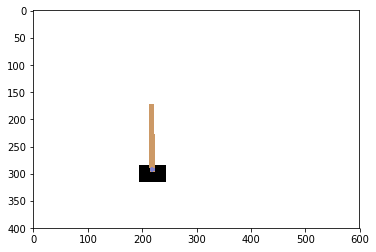

In [14]:
img = plt.imshow(env.render(mode='rgb_array'))
load_torch_model(agent.policy,'model/reinforce_cartpole_iter_200.pth')
frames = play(agent, env, img)

In [32]:
class REINFORCE_MountainCar():
  def __init__(self, env, steps_in_state = 2):
    self.steps_in_state = steps_in_state
    self.policy = PolicyNet_discret(env.observation_space.shape[0] * steps_in_state,env.action_space.n)
    self.env = env
    self._gamma = 0.96
    self._epsilon = 0.2

  def init_state(self, env_state):
    self.running_state_seq = [env_state] * self.steps_in_state
    self.running_state = FloatTensor(self.running_state_seq).view(-1)

  def add_state(self, env_state):
    self.running_state_seq = self.running_state_seq[1:]
    self.running_state_seq.append(env_state)
    self.running_state = FloatTensor(self.running_state_seq).view(-1)

  def get_action(self):
    # get_action does not sample or explore, just take the policy function output and use it
    action = self.policy(self.running_state)
    return action.argmax().item()

  def epsilon(self):
    (1. / (1. + self.decay * self.iterations))
    return self._epsilon
    
  def pick_action(self, state):
    probs = self.policy(state)
    action_dist = Categorical(probs)
    if np.random.rand() < self.epsilon():
      action = self.env.action_space.sample()
    else:
      action = action_dist.sample()
      action = action.item()
    return (action, action_dist.log_prob(FloatTensor([action])))
  
  def update_policy(self, episode):
    (states, actions, rewards, log_probs) = zip(*episode)
    MC_rewards = []
    R = 0
    for r in rewards[::-1]:
      R = r + self._gamma * R
      MC_rewards.insert(0, R)
    loss = []
    for (log_prob, reward) in zip(log_probs, MC_rewards):
      loss.append(-log_prob*reward)
    loss = torch.stack(loss).sum()
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

  def train(self, env, episode, lr=1e-3, checkpoint=100):
    self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, weight_decay=1e-3)
    best_score = 0
    for i in range(episode):
      s0 = env.reset()
      self.init_state(s0)
      state = self.running_state
      episode = []
      episode_ended = False
      score = 0
      while not episode_ended:
        (action, log_prob) =  self.pick_action(state)
        (s1, reward, episode_ended, info) = env.step(action)
        reward = abs(s1[0] - (-0.5))
        episode.append((state, action, reward, log_prob))
        self.add_state(s1)
        next_state = self.running_state
        if episode_ended:
          ended = 1
        else:
          ended = 0
        s0 = s1
        state = next_state
        score += reward
        
      if score > best_score:
        save_torch_model(self.policy, 'model/reinforce_mountaincar_best.pth')
        best_score = score
        print('new best score:',best_score)
        
      if (i + 1) % checkpoint == 0:
        save_torch_model(self.policy,'model/reinforce_mountaincar_iter_%d.pth' %(i+1))
        print(i+1,': score:', score)

      self.update_policy(episode)

In [33]:
env_MC = gym.make('MountainCar-v0')
agent_MC = REINFORCE_MountainCar(env_MC)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [36]:
agent_MC.train(env_MC, 200, lr=1e-3, checkpoint=50)

new best score: 13.973131466355717
new best score: 30.332211930404373
50 : score: 11.936303359432838
100 : score: 16.329909875734476
150 : score: 10.84273817350573
new best score: 33.43971294670785
new best score: 33.87204493711082
200 : score: 17.923291866815568


In [75]:
class PolicyNet_continuous(nn.Module):
  def __init__(self, input_size, output_size):
    super(PolicyNet_continuous,self).__init__()
    self.l1_linear = nn.Linear(input_size,512)
    self.l2_linear = nn.Linear(512,256)
    self.l3_linear = nn.Linear(256,output_size)
    nn.init.kaiming_normal_(self.l1_linear.weight)
    nn.init.kaiming_normal_(self.l2_linear.weight)
    
  def forward(self,x):
    out = F.relu(self.l1_linear(x))
    out = F.relu(self.l2_linear(out))
    out = F.tanh(self.l3_linear(out))
    return out

In [76]:
class REINFORCE_continuous():
  def __init__(self, env, steps_in_state = 2):
    self.steps_in_state = steps_in_state
    self.policy = PolicyNet_continuous(env.observation_space.shape[0] * steps_in_state,1)
    self.env = env
    self.range_scale = (env.action_space.high[0] - env.action_space.low[0]) / 2.0
    self._gamma = 0.96
    self._epsilon = 0.0
  
  def epsilon(self):
    return self._epsilon
  
  def predict(self, state):
    return self.policy(state)
  
  def pick_action(self, state):
    probs = self.predict(state) * self.range_scale
    action_dist = Normal(probs, 0.2)
    if np.random.rand() < self.epsilon():
      action = self.env.action_space.sample()[0]
    else:
      action = action_dist.rsample().item()
    return (action, action_dist.log_prob(FloatTensor([action])))
  
  def update_policy(self, episode):
    (states, actions, rewards, log_probs) = zip(*episode)
    MC_rewards = []
    R = 0
    for r in rewards[::-1]:
      R = r + self._gamma * R
      MC_rewards.insert(0, R)
    loss = []
    for (log_prob, reward) in zip(log_probs, MC_rewards):
      loss.append(-log_prob*reward)
    loss = torch.stack(loss).sum()
    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

  def train(self, env, episode, lr=1e-3, checkpoint=100):
    self.optimizer = torch.optim.Adam(self.policy.parameters(), lr=lr, weight_decay=1e-3)
    best_score = -99999
    for i in range(episode):
      s0 = env.reset()
      seq = [s0] * self.steps_in_state
      state = FloatTensor(seq).view(-1)
      episode = []
      episode_ended = False
      step = 0
      score = 0
      while not episode_ended:
        (action, log_prob) =  self.pick_action(state)
        (s1, reward, episode_ended, info) = env.step([action])
        episode.append((state, action, reward, log_prob))
        seq = seq[1:]
        seq.append(s1)
        next_state = FloatTensor(seq).view(-1)
        step += 1
        if episode_ended:
          ended = 1
          if step < 200:
            # pole tipped over
            reward = 0.0
          else:
            # environment terminate as max step reached
            reward = 1.0
        else:
          ended = 0
        s0 = s1
        state = next_state
        score += reward
        
      if score > best_score:
        save_torch_model(self.policy, 'model/reinforce_mountaincar_best.pth')
        best_score = score
        print('new best score:',best_score)

      if (i + 1) % checkpoint == 0:
        save_torch_model(self.policy,'model/reinforce_mountaincar_iter_%d.pth' %(i+1))
        print(i+1,': score:', score)

      self.update_policy(episode)



In [77]:
env = gym.make('Pendulum-v0')
# env = gym.make('MountainCarContinuous-v0')
agent = REINFORCE_continuous(env)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [78]:
agent.train(env, 500, lr=1e-3, checkpoint=100)

new best score: -1453.4346701422298
new best score: -1344.229292963753
new best score: -1021.2208387193907
new best score: -833.7026407974064
new best score: -829.011154336805
100 : score: -1188.859591652436
new best score: -823.0727270718667
200 : score: -1635.3359380956833
300 : score: -1578.5392590559215
new best score: -752.1505662111351
400 : score: -1063.1799564137377
500 : score: -1640.118534303802


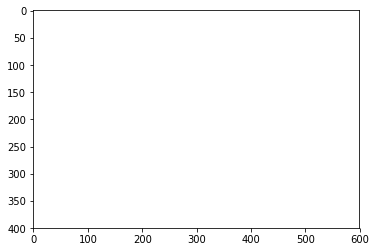

In [2]:
env = gym.make('CartPole-v0')
env.reset()
img = plt.imshow(env.render(mode='rgb_array')) # only call this once
for _ in range(100):
    img.set_data(env.render(mode='rgb_array')) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)
    action = env.action_space.sample()
    env.step(action)